In [104]:
import pandas as pd
import numpy as np
import pulp as pl

In [106]:
df = pd.read_csv('Historical Product Demand.csv')
df.head()

Product_Code Warehouse Product_Category       Date Order_Demand
0  Product_0993    Whse_J     Category_028  2012/7/27         100 
1  Product_0979    Whse_J     Category_028  2012/1/19         500 
2  Product_0979    Whse_J     Category_028   2012/2/3         500 
3  Product_0979    Whse_J     Category_028   2012/2/9         500 
4  Product_0979    Whse_J     Category_028   2012/3/2         500

In [108]:
print("DataFrame Info:")
df.info()

print("\nSummary Statistics:")
print(df.describe())

print("\nMissing Values per Column:")
print(df.isnull().sum())

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   Product_Code      1048575 non-null  object
 1   Warehouse         1048575 non-null  object
 2   Product_Category  1048575 non-null  object
 3   Date              1037336 non-null  object
 4   Order_Demand      1048575 non-null  object
dtypes: object(5)
memory usage: 40.0+ MB

Summary Statistics:
        Product_Code Warehouse Product_Category       Date Order_Demand
count        1048575   1048575          1048575    1037336      1048575
unique          2160         4               33       1729         3828
top     Product_1359    Whse_J     Category_019  2013/9/27        1000 
freq           16936    764447           481099       2075       112682

Missing Values per Column:
Product_Code            0
Warehouse               0
Product_Category        0
Date    

In [110]:
# convert 'Date' column to a proper datetime format
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# check if order_demand is numeric
df['Order_Demand'] = pd.to_numeric(df['Order_Demand'], errors='coerce')

# drop rows where order_demand is missing or negative
df = df.dropna(subset=['Order_Demand'])          
df = df[df['Order_Demand'] > 0]                 

# after cleaning
print("Data after cleaning:")
print(df.info())
print(df.describe())

Data after cleaning:
<class 'pandas.core.frame.DataFrame'>
Index: 1009425 entries, 0 to 1048574
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   Product_Code      1009425 non-null  object        
 1   Warehouse         1009425 non-null  object        
 2   Product_Category  1009425 non-null  object        
 3   Date              1002765 non-null  datetime64[ns]
 4   Order_Demand      1009425 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 46.2+ MB
None
                                Date  Order_Demand
count                        1002765  1.009425e+06
mean   2014-06-19 12:42:03.031817728  5.076749e+03
min              2011-01-08 00:00:00  1.000000e+00
25%              2013-04-03 00:00:00  2.500000e+01
50%              2014-06-17 00:00:00  3.000000e+02
75%              2015-08-31 00:00:00  2.000000e+03
max              2017-01-09 00:00:00  4.000000

In [112]:
# create a new column month from the date
df['Month'] = df['Date'].dt.to_period('M')

# group by warehouse, product category, and month to sum the demand
monthly_demand = df.groupby(['Warehouse', 'Product_Category', 'Month'])['Order_Demand'].sum().reset_index()

# convert month back to string
monthly_demand['Month'] = monthly_demand['Month'].astype(str)

print("\nMonthly Demand (head):")
print(monthly_demand.head(10))


Monthly Demand (head):
  Warehouse Product_Category    Month  Order_Demand
0    Whse_A     Category_001  2013-06          51.0
1    Whse_A     Category_001  2013-07          37.0
2    Whse_A     Category_001  2013-08          32.0
3    Whse_A     Category_001  2013-09          60.0
4    Whse_A     Category_001  2013-11          52.0
5    Whse_A     Category_001  2014-01          44.0
6    Whse_A     Category_001  2014-02         139.0
7    Whse_A     Category_001  2014-03         187.0
8    Whse_A     Category_001  2014-04          63.0
9    Whse_A     Category_001  2014-05          29.0


In [114]:
# get unique values for warehouses, product categories, and months
warehouses = monthly_demand['Warehouse'].unique()
categories = monthly_demand['Product_Category'].unique()
months = monthly_demand['Month'].unique()

# simulate warehouse supply
# for each warehouse, category, month - supply = historical demand * 1.2 (for buffer) or 100 if no historical demand
supply_data = []
for wh in warehouses:
    for cat in categories:
        for m in months:
            hist_demand = monthly_demand[
                (monthly_demand['Warehouse'] == wh) & 
                (monthly_demand['Product_Category'] == cat) & 
                (monthly_demand['Month'] == m)
            ]['Order_Demand']
            demand_val = hist_demand.values[0] if not hist_demand.empty else 0
            supply_val = demand_val * 1.2 if demand_val > 0 else 100
            supply_data.append({
                'Warehouse': wh,
                'Product_Category': cat,
                'Month': m,
                'Supply': supply_val
            })

df_supply = pd.DataFrame(supply_data)
print("\nSimulated Warehouse Supply (first 10 rows):")
print(df_supply.head(10))


Simulated Warehouse Supply (first 10 rows):
  Warehouse Product_Category    Month  Supply
0    Whse_A     Category_001  2013-06    61.2
1    Whse_A     Category_001  2013-07    44.4
2    Whse_A     Category_001  2013-08    38.4
3    Whse_A     Category_001  2013-09    72.0
4    Whse_A     Category_001  2013-11    62.4
5    Whse_A     Category_001  2014-01    52.8
6    Whse_A     Category_001  2014-02   166.8
7    Whse_A     Category_001  2014-03   224.4
8    Whse_A     Category_001  2014-04    75.6
9    Whse_A     Category_001  2014-05    34.8


In [115]:
# define regions categories and months
regions = ['Region_A', 'Region_B', 'Region_C']
categories = df_supply['Product_Category'].unique()
months = df_supply['Month'].unique()

# for each (region, category, month) simulate demand as a random fraction (80%-100%) of the average supply
demand_data = []
for reg in regions:
    for cat in categories:
        for m in months:
            subset = df_supply[(df_supply['Product_Category'] == cat) & (df_supply['Month'] == m)]
            avg_supply_value = subset['Supply'].mean()
            avg_supply_value = avg_supply_value if pd.notnull(avg_supply_value) else 100
            demand_val = round(np.random.uniform(0.8, 1.0) * avg_supply_value, 2)
            demand_data.append({
                'Region': reg,
                'Product_Category': cat,
                'Month': m,
                'Demand': demand_val
            })

df_demand = pd.DataFrame(demand_data)
print("\nSimulated Region Demand (first 10 rows):")
print(df_demand.head(10))


Simulated Region Demand (first 10 rows):
     Region Product_Category    Month   Demand
0  Region_A     Category_001  2013-06  6665.58
1  Region_A     Category_001  2013-07  7649.69
2  Region_A     Category_001  2013-08  6270.98
3  Region_A     Category_001  2013-09  6870.74
4  Region_A     Category_001  2013-11  6995.60
5  Region_A     Category_001  2014-01  7133.55
6  Region_A     Category_001  2014-02  7090.67
7  Region_A     Category_001  2014-03  9337.03
8  Region_A     Category_001  2014-04  7186.19
9  Region_A     Category_001  2014-05  7063.14


In [116]:
# for each (warehouse, region) pair, generate a shipping cost per unit between 2 and 6 dollars
np.random.seed(42)  # for reproducibility
cost_data = []
for wh in warehouses:
    for reg in regions:
        cost_data.append({
            'Warehouse': wh,
            'Region': reg,
            'CostPerUnit': round(np.random.uniform(2, 6), 2)
        })

df_cost = pd.DataFrame(cost_data)
print("\nSimulated Shipping Cost Matrix:")
print(df_cost)


Simulated Shipping Cost Matrix:
   Warehouse    Region  CostPerUnit
0     Whse_A  Region_A         3.50
1     Whse_A  Region_B         5.80
2     Whse_A  Region_C         4.93
3     Whse_C  Region_A         4.39
4     Whse_C  Region_B         2.62
5     Whse_C  Region_C         2.62
6     Whse_J  Region_A         2.23
7     Whse_J  Region_B         5.46
8     Whse_J  Region_C         4.40
9     Whse_S  Region_A         4.83
10    Whse_S  Region_B         2.08
11    Whse_S  Region_C         5.88


In [170]:
# build dictionaries from our simulated data:
# supply dictionary: key = (Warehouse, Product_Category, Month)
supply_dict = {}
for idx, row in df_supply.iterrows():
    key = (row['Warehouse'], row['Product_Category'], row['Month'])
    supply_dict[key] = row['Supply']

# Demand dictionary
demand_dict = {}
for idx, row in df_demand.iterrows():
    key = (row['Region'], row['Product_Category'], row['Month'])
    demand_dict[key] = row['Demand']

# Cost dictionary
cost_dict = {}
for idx, row in df_cost.iterrows():
    key = (row['Warehouse'], row['Region'])
    cost_dict[key] = row['CostPerUnit']

# linear programming: Minimization
model = pl.LpProblem("SupplyChainOptimization", pl.LpMinimize)

# create decision variables for shipments
# variable: x[w, r, cat, m] = number of units shipped from warehouse w to region r
# for product category cat in month m.
shipment_vars = {}
for w in warehouses:
    for r in regions:
        for cat in categories:
            for m in months:
                var_name = f"x_{w}_{r}_{cat}_{m}"
                shipment_vars[(w, r, cat, m)] = pl.LpVariable(var_name, lowBound=0, cat='Continuous')

# minimize the total shipping cost: sum(cost per unit * shipment amount)
model += pl.lpSum([cost_dict[(w, r)] * shipment_vars[(w, r, cat, m)]
                   for w in warehouses
                   for r in regions
                   for cat in categories
                   for m in months]), "Total_Shipping_Cost"

# add supply constraints:
# for each (Warehouse, Product_Category, Month), total shipment out cannot exceed supply.
for w in warehouses:
    for cat in categories:
        for m in months:
            key = (w, cat, m)
            supply_value = supply_dict.get(key, 0) 
            model += (pl.lpSum([shipment_vars[(w, r, cat, m)] for r in regions]) 
                      <= supply_value), f"Supply_Constraint_{w}_{cat}_{m}"

# add demand constraints:
# for each (Region, Product_Category, Month), total shipment in must at least meet the demand.
for r in regions:
    for cat in categories:
        for m in months:
            key = (r, cat, m)
            demand_value = demand_dict.get(key, 0)  # Default to 0 if key not found
            model += (pl.lpSum([shipment_vars[(w, r, cat, m)] for w in warehouses])
                      >= demand_value), f"Demand_Constraint_{r}_{cat}_{m}"

model.solve()

print("Status:", pl.LpStatus[model.status])
print("Total Shipping Cost =", pl.value(model.objective))

print("\nOptimal Shipment Plan (non-zero shipments):")
for key, var in shipment_vars.items():
    if var.varValue > 0:
        print(f"Shipment {key}: {var.varValue}")

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Applications/anaconda3/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/rr/1my9dxj92ql5lbtcf0nwfz6r0000gn/T/782a15fca4824c5d96da647221bedab8-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/rr/1my9dxj92ql5lbtcf0nwfz6r0000gn/T/782a15fca4824c5d96da647221bedab8-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 15713 COLUMNS
At line 96498 RHS
At line 112207 BOUNDS
At line 112208 ENDATA
Problem MODEL has 15708 rows, 26928 columns and 53856 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 15708 (0) rows, 26928 (0) columns and 53856 (0) elements
Perturbing problem by 0.001% of 5.88 - largest nonzero change 3.7335476e-05 ( 0.00088152922%) - largest zero change 0
0  Obj 5.7833071e+08 Primal inf 4.0149849e+09 (6732)
303  Obj 1.0250942e+10 Primal inf 4.6156401e+0

In [119]:
# create a datframe from the optimal shipments plan
shipment_results = []
for (w, r, cat, m), var in shipment_vars.items():
    if var.varValue > 0:
        shipment_results.append({
            'Warehouse': w,
            'Region': r,
            'Product_Category': cat,
            'Month': m,
            'Units_Shipped': var.varValue,
            'CostPerUnit': cost_dict[(w, r)],
            'TotalCost': var.varValue * cost_dict[(w, r)]
        })

df_shipments = pd.DataFrame(shipment_results)
print("\nOptimal Shipment Plan:")
print(df_shipments)


Optimal Shipment Plan:
      Warehouse    Region Product_Category    Month  Units_Shipped  \
0        Whse_A  Region_A     Category_001  2017-01          33.40   
1        Whse_A  Region_A     Category_003  2013-06         762.95   
2        Whse_A  Region_A     Category_003  2013-07        1121.27   
3        Whse_A  Region_A     Category_003  2013-08        1551.19   
4        Whse_A  Region_A     Category_003  2013-09        1093.65   
...         ...       ...              ...      ...            ...   
10588    Whse_S  Region_C     Category_025  2013-04        1710.34   
10589    Whse_S  Region_C     Category_025  2013-12       10512.65   
10590    Whse_S  Region_C     Category_025  2015-01        3642.08   
10591    Whse_S  Region_C     Category_025  2015-03        6029.26   
10592    Whse_S  Region_C     Category_025  2015-09        4955.60   

       CostPerUnit   TotalCost  
0             3.50    116.9000  
1             3.50   2670.3250  
2             3.50   3924.4450  
3  

In [120]:
# aggregate shipment data by Warehouse and Region
shipment_summary = df_shipments.groupby(['Warehouse', 'Region']).agg({
    'Units_Shipped': 'sum',
    'TotalCost': 'sum'
}).reset_index()

print("Shipment Summary by Warehouse and Region:")
print(shipment_summary)

Shipment Summary by Warehouse and Region:
   Warehouse    Region  Units_Shipped     TotalCost
0     Whse_A  Region_A   1.849764e+06  6.474176e+06
1     Whse_A  Region_B   2.327225e+06  1.349791e+07
2     Whse_A  Region_C   1.056793e+07  5.209990e+07
3     Whse_C  Region_A   2.795770e+06  1.227343e+07
4     Whse_C  Region_B   1.886309e+08  4.942129e+08
5     Whse_C  Region_C   5.072860e+08  1.329089e+09
6     Whse_J  Region_A   1.370862e+09  3.057022e+09
7     Whse_J  Region_B   5.769315e+07  3.150046e+08
8     Whse_J  Region_C   8.587174e+08  3.778357e+09
9     Whse_S  Region_A   1.108440e+07  5.353767e+07
10    Whse_S  Region_B   1.139423e+09  2.369999e+09
11    Whse_S  Region_C   6.495443e+06  3.819321e+07


In [172]:
df_shipments.style.format({
    'Units_Shipped': '{:,.0f}',      
    'CostPerUnit': '${:,.2f}',       
    'TotalCost': '${:,.2f}'          
})

In [176]:
df_shipments.to_csv('optimal_shipment_plan.csv', index=False)
shipment_summary.to_csv('shipment_summary.csv', index=False)

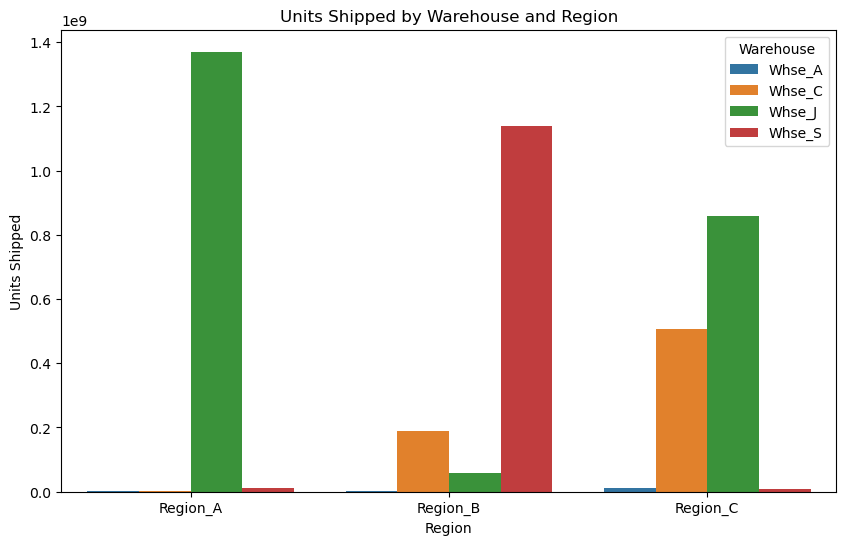

In [128]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.barplot(data=shipment_summary, x='Region', y='Units_Shipped', hue='Warehouse')
plt.title('Units Shipped by Warehouse and Region')
plt.xlabel('Region')
plt.ylabel('Units Shipped')
plt.show()

Text(0.5, 0, 'Month')

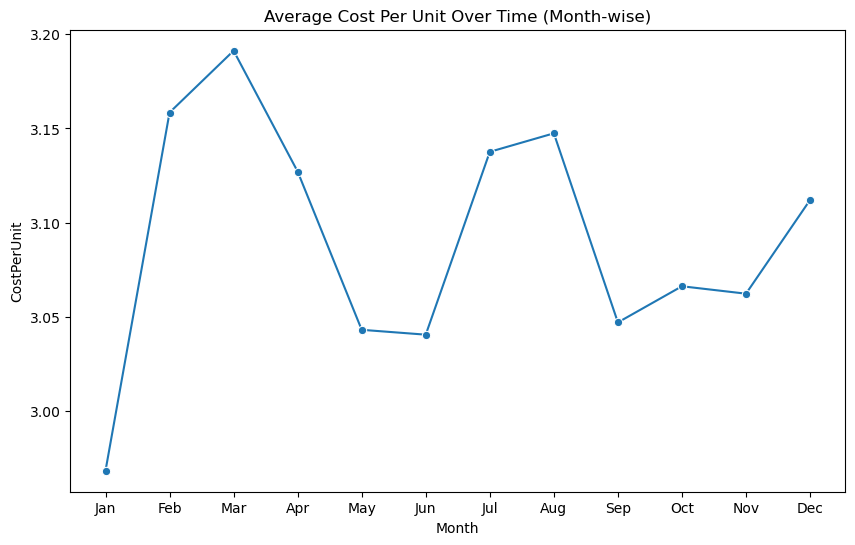

In [180]:
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("optimal_shipment_plan.csv")

df["Month"] = pd.to_datetime(df["Month"], errors="coerce")
df.sort_values("Month", inplace=True)
df["MonthName"] = df["Month"].dt.strftime('%b')

avg_cost_by_month = df.groupby("MonthName")["CostPerUnit"].mean().reset_index()


month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
avg_cost_by_month["MonthName"] = pd.Categorical(avg_cost_by_month["MonthName"], 
                                               categories=month_order, 
                                               ordered=True)
avg_cost_by_month.sort_values("MonthName", inplace=True)

plt.figure(figsize=(10, 6))
sns.lineplot(data=avg_cost_by_month, x="MonthName", y="CostPerUnit", marker="o")
plt.title("Average Cost Per Unit Over Time (Month-wise)")
plt.xlabel("Month")

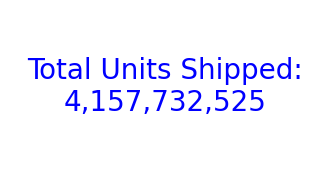

In [168]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(4, 2))
ax.axis('off')  

ax.text(0.5, 0.5, f"Total Units Shipped:\n{total_units:,.0f}",
        horizontalalignment='center',
        verticalalignment='center',
        fontsize=20,
        color='blue') 

plt.show()